# Code sketch for a particular analysis of electoral polls in Spain

This notebook contains sample code for a particular kind of analysis of electoral polls in Madrid. Specifically:

* In the sake of simplicity, only one political party is analyzed. The interested reader should know how to extend the analysis (hint: use loops) for other particular parties of his interest.
* The timeframe for this analysis is the 2022-2023 period. Some changes would be needed in the code below to analyze other periods.

In [125]:
import pandas as pd
import numpy as np
from datetime import datetime

from jax import random, vmap

import numpyro
from numpyro.distributions import Normal, HalfNormal, Gamma
from numpyro.infer import MCMC, NUTS

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)

## Data and all that

In the following block, many things happen. I have omitted the prescriptive EDA, etc., but it should be obvious to the reader that most of the operations below happen for a reason.

Polls data comes from [Electocracia](https://electocracia.com/). My sincere thanks to them would be substantially more effusive should they keep their data cleaner.

The selected party has been the one with data closer to the poll metadata, i.e., the _first_ one. It will not be named in what follows. Variable `pct` will contain the _% of vote_ (whatever that means) for that particular party.

In [126]:
tables = pd.read_html('https://electocracia.com/')
polls = tables[1]
polls = polls.iloc[:, 0:6]

polls.columns = ['medio', 'fuente', 'fecha', 'fin_campo', 'n', 'pct']
polls = polls.drop('fin_campo', axis=1)

polls.loc[polls.fuente == 'SigmaDos', 'fuente'] = 'Sigma Dos'
polls.loc[polls.fuente == 'Mestroscopia', 'fuente'] = 'Metroscopia'
polls.loc[polls.fuente == 'Instituto DYM', 'fuente'] = 'DYM'
polls.loc[polls.fuente == 'Socio Métrica', 'fuente'] = 'Sociométrica'
polls.loc[polls.fuente == 'SocioMétrica', 'fuente'] = 'Sociométrica'
polls.loc[polls.fuente == 'Hamalgama Métrica', 'fuente'] = 'Hamalgama'
polls.loc[polls.fuente == 'SYM Consulting', 'fuente'] = 'SYM'
polls.loc[polls.fuente == 'Imop insights', 'fuente'] = 'IMOP'
polls.loc[polls.fuente == 'IMOP Insights', 'fuente'] = 'IMOP'
polls.loc[polls.fuente == '40dB', 'fuente'] = '40db'

polls.loc[polls.fecha == '17/12/18', 'fecha'] = '17/12/2018'
polls.loc[polls.fecha == '16/12/18', 'fecha'] = '16/12/2018'

polls['fecha'] = pd.to_datetime(polls['fecha'], format='%d/%m/%Y')

# imputation of missing values (!)
polls.loc[polls.n.isna(), 'n'] = polls.n.median()

polls.loc[polls.pct > 100, 'pct'] = 31.6
polls = polls[polls.fecha.dt.year >= 2020]

This is what the data looks like. For most purposes, most statisticians, given similar data, would do little more than a linear regression or some kind of local regression. But we want to do better.

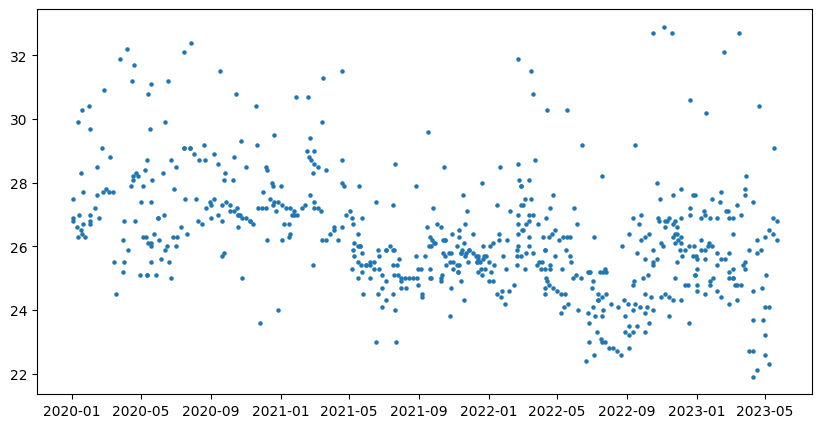

In [127]:
plt.scatter(polls.fecha, polls.pct, s = 5);

## Preparing the data for the analysis

Dates to integers:

In [128]:
first_day = polls.fecha.min()
polls['day'] = polls.fecha.map(lambda x: (x - first_day).days)

Pollster names to numerical indexes:

In [129]:
x = enumerate(polls.fuente.drop_duplicates())
fuente_dict = pd.DataFrame(x, columns=['pollster_id', 'fuente'])
polls = pd.merge(polls, fuente_dict)

Sample sizes to _error factors_. 

Note that, loosely speaking, the estimation $\hat{p}$ of the proportion of interest $p$ has a distribution $N(p, \sigma / \sqrt{n})$. In the models below, $\sigma$ will be a parameter to be estimated, but the _error factor_ $n^{-.5}$ will be provided. 

Note that given that we are fitting percentages, $\sigma$ will be a parameter theoretically bounded by 50.

In [130]:
polls['error_factor'] = 1 / np.sqrt(np.array(polls.n))

In [131]:
polls

,medio,fuente,fecha,n,pct,day,pollster_id,error_factor
0,El Diario,Simple Lógica,2023-05-22,1013.0,26.2,1236,0,0.031419
1,El Diario,Simple Lógica,2023-04-17,1014.0,26.2,1201,0,0.031404
2,El Diario,Simple Lógica,2023-03-19,1028.0,27.0,1172,0,0.031189
3,El Diario,Simple Lógica,2023-02-13,1240.0,27.7,1138,0,0.028398
4,El Diario,Simple Lógica,2023-01-16,1012.0,27.0,1110,0,0.031435
...,...,...,...,...,...,...,...,...
641,CIS,Intercampo,2020-04-15,3000.0,31.2,104,24,0.018257
642,Público,Sináptica,2020-05-11,1001.0,25.1,130,25,0.031607
643,La Nueva Crónica,SyC Consulting,2020-03-30,3104.0,26.2,88,26,0.017949
644,eldiario.es,Celeste-Tel,2020-02-13,1100.0,27.6,42,27,0.030151


Other values needed by the model:

In [132]:
n_days = polls.day.max() + 1
n_pollsters = polls.fuente.nunique()

## The model

Polls attempt to measure the value of an underlying hidden Markov process $y$ which I will model as

$$y_{t+1} = y_t + \Delta_t$$

where $\Delta_t \sim N(0, \sigma_\text{hmm})$. It is expected this $\sigma_\text{hmm}$ not to be too big. Our prior is that vote intention will not typically move by more than 1% in a given day, so, the prior for this variable will be a half-normal with sd of $.5$.

(As an alternative, I could have used [this tool](http://priors.datanalytics.com/) to select a gamma prior with a nice typical range between, say, 0.1% and 1%.)

In the model, each pollster has a _bias_ favouring (or not) this political party. The prior of this bias is a $N(0, \sigma_\text{bias})$ distribution and the prior of $\sigma_\text{bias}$ has been chosen so that biases of $\pm 4\%$ should be rare, i.e, as a half-normal with sd = $2$.

Finally, the sample error (which has been discussed above) is the following product: `σ * error_factor`. For the first one, expected to be something close to $\sqrt{y(1-y)}$ in the percentage scale, i.e., about 40-45, we have selected a gamma prior with parameters 61 and 1.6, which has a 90% probability range between 30% and 45%.

The resulting model is:

In [133]:
def polls_model(pct, poll_day, pollster_id, error_factor):

    # Measurement sd prior
    σ = numpyro.sample("σ_measure", Gamma(61, 1.6))

    # Hidden Markov Model
    σ_hmm = numpyro.sample("σ_hmm", HalfNormal(.5))
    with numpyro.plate("deltas", n_days):
        Δ = numpyro.sample("Δ", Normal(0, σ_hmm))     
    y = pct[0] + np.cumsum(Δ)

    # Bias
    σ_bias = numpyro.sample("σ_bias", HalfNormal(2))
    with numpyro.plate("biases", n_pollsters):
        bias = numpyro.sample("bias", Normal(0, σ_bias))    

    # Expected pool "estimate"
    mu = y[poll_day] + bias[pollster_id]

    # Actual poll measurement
    with numpyro.plate("polls", len(pct)):
        numpyro.sample("poll", Normal(mu, σ * error_factor), obs = pct)

In [134]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(polls_model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)

mcmc.run(
    rng_key_, 
    pct=polls.pct.values, 
    poll_day = polls.day.values, 
    pollster_id = polls.pollster_id.values, 
    error_factor = polls.error_factor.values)

sample: 100%|██████████| 3000/3000 [01:00<00:00, 49.53it/s, 255 steps of size 1.11e-02. acc. prob=0.94]


## Some results

In [135]:
#mcmc.print_summary()
samples = mcmc.get_samples()    

First, the hidden Markov model:

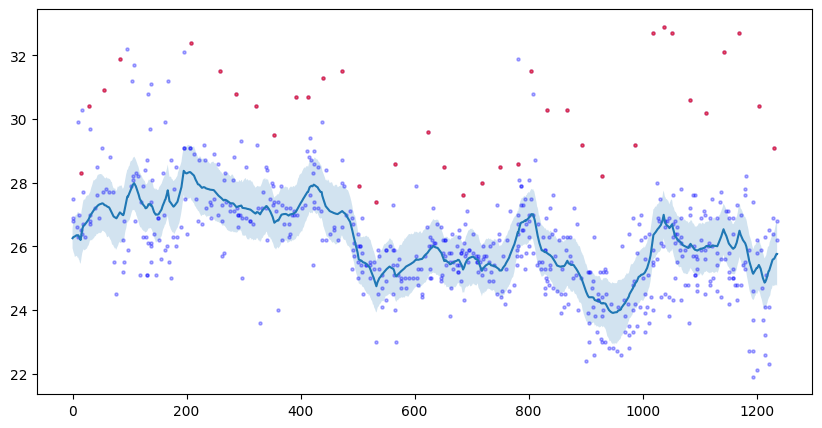

In [136]:
hmm = samples['Δ']
hmm = polls.pct.values[0] + np.cumsum(hmm, axis=1)
my_mean = hmm.mean(axis = 0)
low = np.quantile(hmm, 0.025, axis = 0)
upper = np.quantile(hmm, 0.975, axis = 0)

cis = polls[polls.fuente == 'CIS']

plt.plot(my_mean);
plt.fill_between(range(len(low)), low, upper, alpha=0.2)

plt.scatter(polls.day, polls.pct, s = 5, color = 'blue', alpha = 0.3)
plt.scatter(cis.day, cis.pct, s = 5, color = 'red', alpha = 0.5);

Now, the bias by pollster:

In [137]:
bias = pd.DataFrame(samples['bias'], columns = fuente_dict.fuente)

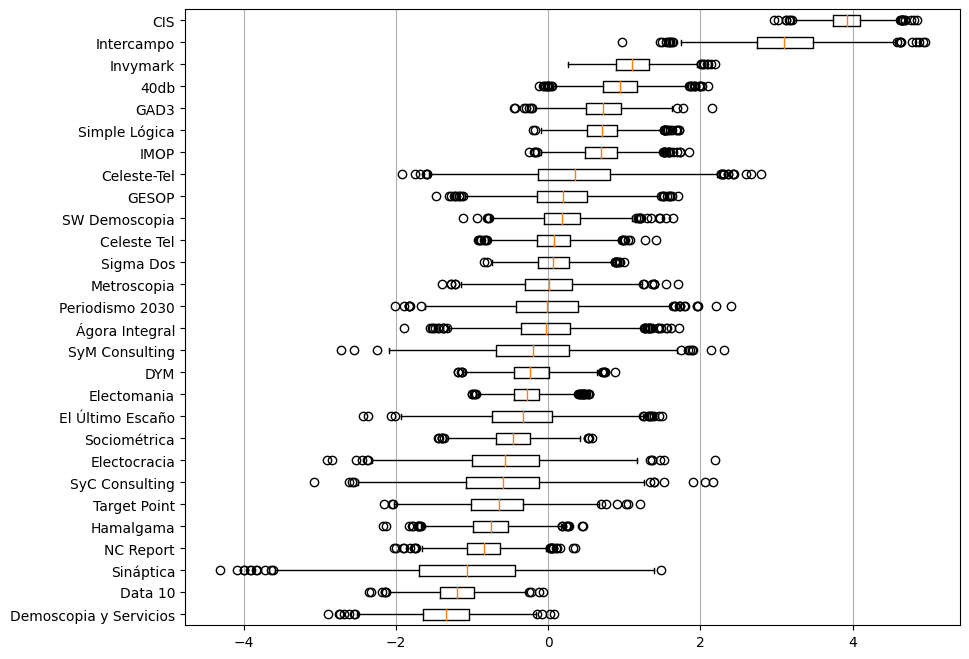

In [138]:
medians = bias.mean()
sorted_columns = medians.sort_values().index
bias_alt = bias[sorted_columns]

plt.figure(figsize=(10, 8))
plt.boxplot(bias_alt.values, vert = False)
plt.grid(axis = 'x')
plt.yticks(range(1, len(bias_alt.columns) + 1), bias_alt.columns);